In [2]:
import numpy as np
import cv2 as cv
import glob
import os
import logging
import Utils
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R


## Code for Computing Intrinsic Calibration

In [4]:
import numpy as np
import cv2 as cv
import glob
import os
import logging
import Utils

logging.basicConfig(level=logging.INFO)

# CALIB PARAMS
folderPath = "../data/20240823_phantom_stereo/checkerboard"
fileName = "right.mp4"
filePath = f"{folderPath}/{fileName}"


# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((10*7,3), np.float32)
objp[:,:2] = np.mgrid[0:10,0:7].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

# TODO: Adapt MP4 read
imgs = Utils.VideoToFrames(filePath, frameRange=(305, 1500, 3)) # glob.glob('*.jpg')
gray = cv.cvtColor(imgs[0], cv.COLOR_BGR2GRAY)

logging.info("Finding chessboard corners in video frames...")
for img in imgs:
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (10, 7),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        cv.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners)

        # Draw and display the corners
        cv.drawChessboardCorners(img, (10,7), corners,ret)
        # cv.imshow('img',img)
        # cv.waitKey(100)
logging.info(f"All video frames processed! Chessboard corners found in {len(imgpoints)} images.")


cv.destroyAllWindows()
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print(ret)
print("\n\n")
print(mtx)
print("\n\n")
print(dist)
print("\n\n")
# print(rvecs)
# print("\n\n")
# print(tvecs)
# print("\n\n")

mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2)/len(imgpoints2)
    mean_error += error
 
print( "total error: {}".format(mean_error/len(objpoints)) )


INFO:root:Reading video file ../data/20240823_phantom_stereo/checkerboard/right.mp4...


INFO:root:Video file read! 399 frames read.
INFO:root:Finding chessboard corners in video frames...


KeyboardInterrupt: 

## Computing Frame Temporal Offset between Left and Right Frames of Prostate
Check for checkboard too, but they should be similar.

In [40]:
folderPath = "../data/20240823_phantom_stereo/prostate"

leftTimeFilePath = f"{folderPath}/left_time.txt"
rightTimeFilePath = f"{folderPath}/right_time.txt"

In [41]:
leftTimes = np.genfromtxt(leftTimeFilePath, delimiter=" ", dtype=np.double)
rightTimes = np.genfromtxt(rightTimeFilePath, delimiter=" ", dtype=np.double)
if leftTimes[0, 1] <= rightTimes[0, 1]:
    earlierStartTime = leftTimes
    laterStartTime = rightTimes
    print("left camera started earlier")
else:
    earlierStartTime = rightTimes
    laterStartTime = leftTimes
    print("right camera started earlier")

curMinOffset = np.inf
curMinIdx = 0
for i in range(earlierStartTime.shape[0]):
    tDiff = (laterStartTime[0, 1] - earlierStartTime[i, 1]) * 1e-3 # micro s
    if (abs(tDiff) < curMinOffset):
        curMinOffset = tDiff
        curMinIdx = i

print(f"earlier start frame idx {curMinIdx}, frame # {earlierStartTime[curMinIdx, 0]}, {curMinOffset}")


left camera started earlier
earlier start frame idx 6, frame # 3577.0, -1524.224


2298.47978714827
8123.136


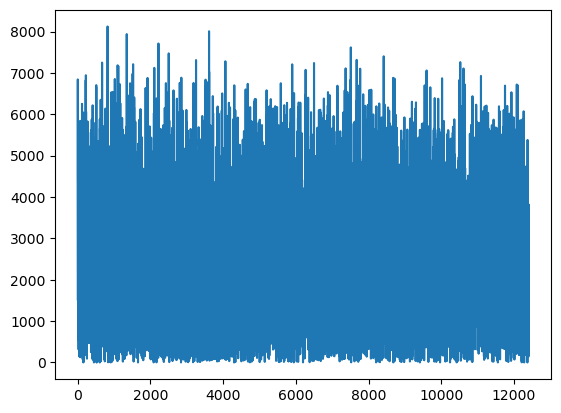

In [42]:
tOffset = 6
tDiffs = []
for i in range(0, min(earlierStartTime.shape[0] - tOffset, laterStartTime.shape[0])):
    tDiff = (laterStartTime[i, 1] - earlierStartTime[i + tOffset, 1]) * 1e-3 # micro s
    tDiffs.append(abs(tDiff))

print(np.mean(tDiffs))
print(np.max(tDiffs))

plt.plot(tDiffs)

## Computing Essential Matrix, Given Computed Pairs of Extrinsic Matrices

In [91]:
cameraExtrinsics = np.load("./calibration_results/cameraPairExtrinsic_20241015_181311.npy")

In [92]:
cameraExtrinsics.shape

def rtVecToTransform(rvec, tvec):
    RMat,_ = cv.Rodrigues(rvec)
    outMat = np.eye(4)
    outMat[:3, :3] = RMat
    outMat[:3, 3] = tvec
    return outMat


def rtVecToTransformReversedOrder(rvec, tvec):
    RMat,_ = cv.Rodrigues(rvec)
    outMatR = np.eye(4)
    outMatT = np.eye(4)
    outMatR[:3, :3] = RMat
    outMatT[:3, 3] = tvec
    return outMatR @ outMatT

leftToRightTs = []
rightToLeftTs = []
leftTs = []
rightTs = []
for iFrame in range(cameraExtrinsics.shape[1]):
    leftT = rtVecToTransform(rvec=cameraExtrinsics[0, iFrame, 0, :, 0], tvec=cameraExtrinsics[0, iFrame, 0, :, 0])
    rightT = rtVecToTransform(rvec=cameraExtrinsics[1, iFrame, 0, :, 0], tvec=cameraExtrinsics[1, iFrame, 0, :, 0])
    leftTs.append(leftT)
    rightTs.append(rightT)
    leftToRightTs.append(rightT @ np.linalg.inv(leftT))

In [93]:
cameraExtrinsics[0][0]

array([[[-0.12301236],
        [ 0.20037249],
        [ 1.55712915]],

       [[-1.78443826],
        [-6.36476587],
        [20.88509199]]])

In [94]:
leftMotionTs = []
rightMotionTs = []
for iFrame in range(cameraExtrinsics.shape[1]-3):
    leftMotionTs.append(leftTs[iFrame+3] @ np.linalg.inv(leftTs[iFrame]))
    rightMotionTs.append(rightTs[iFrame+3] @ np.linalg.inv(rightTs[iFrame]))

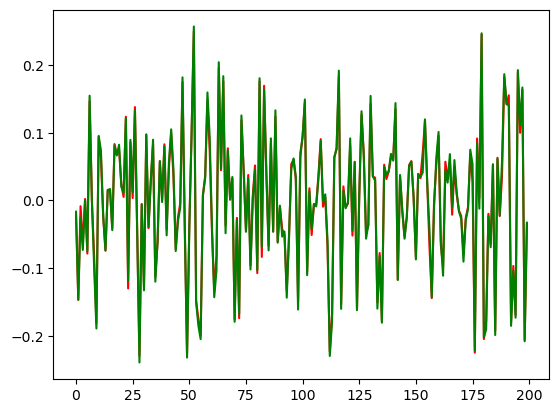

In [95]:
plt.plot([t[0, 3] for t in leftMotionTs[300:500]], "r")
plt.plot([t[0, 3] for t in rightMotionTs[300:500]], "g")

In [96]:
print(np.std([t[0, 3] for t in leftToRightTs]))
print(np.mean([t[0, 3] for t in leftToRightTs]))

0.0050582581401145315
-0.012274887005622953


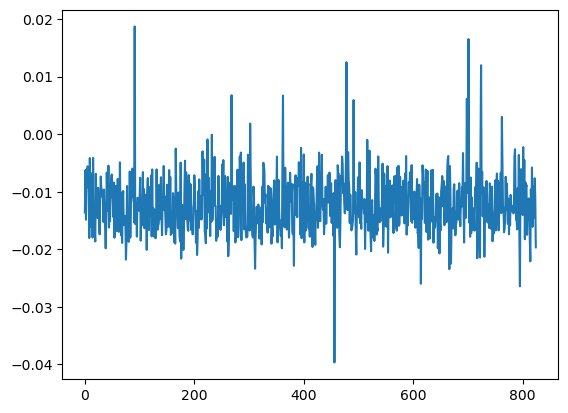

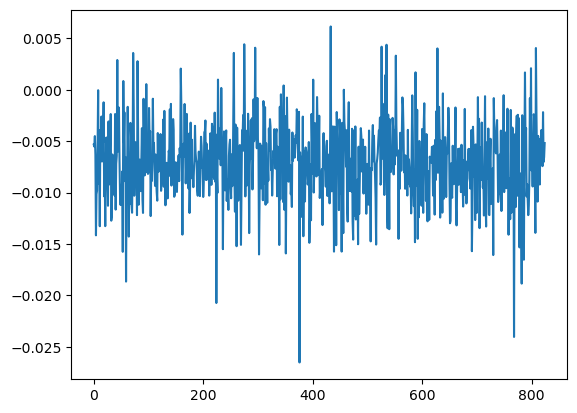

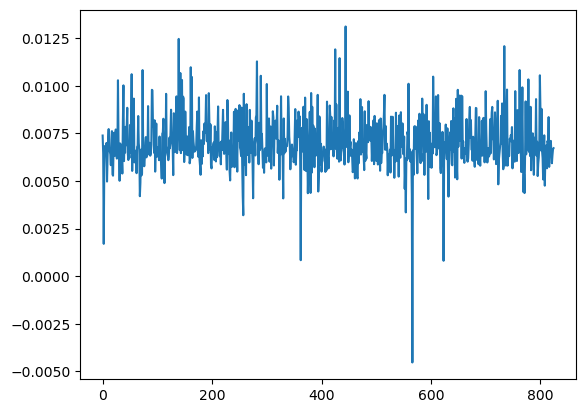

In [97]:
plt.plot([t[0, 3] for t in leftToRightTs])
plt.figure()
plt.plot([t[1, 3] for t in leftToRightTs])
plt.figure()
plt.plot([t[2, 3] for t in leftToRightTs])

In [98]:
# "Average" Transforms
quatOut = np.zeros((4, 1))
tOut = np.mean([t[:3, 3] for t in leftToRightTs], axis=0)

quaternion0 = R.from_matrix(leftToRightTs[0][:3, :3]).as_quat()
quaternions = []
for TMat in leftToRightTs:
    curRMat = TMat[:3, :3]
    rotation = R.from_matrix(curRMat)
    quaternion = rotation.as_quat()
    if quaternion.dot(quaternion0) < 0.0:
        quaternion *= -1.
    quaternions.append(quaternion)

quatOut = np.mean(quaternions, axis=0)
quatOut /= np.linalg.norm(quatOut)


In [99]:
rOut = R.from_quat(quatOut)
vOut = tOut
matOut = np.eye(4)
matOut[:3, :3] = rOut.as_matrix()
matOut[:3, 3] = vOut
matOutInv = np.linalg.inv(matOut)

In [100]:
matOut

array([[ 0.99997518, -0.00581077,  0.00398304, -0.01227489],
       [ 0.00576046,  0.99990494,  0.01252703, -0.00704765],
       [-0.00405545, -0.01250377,  0.9999136 ,  0.00698587],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [101]:
matOutInv

array([[ 0.99997518,  0.00576046, -0.00405545,  0.01234351],
       [-0.00581077,  0.99990494, -0.01250377,  0.007063  ],
       [ 0.00398304,  0.01252703,  0.9999136 , -0.00684809],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [113]:
leftIntrinsic = {
    "Intrinsics": np.array(
        [[616.25592128,   0.,         361.65777105],
        [  0.,         618.5552621,  233.81524659],
        [  0.,           0.,           1.        ]]),
    "distortions": np.array(
        [[-0.31521841,  0.64575692, -0.00443106, -0.00141811, -0.20538541]]    )
        }


rightIntrinsic = {
    "Intrinsics": np.array(       
        [[628.43199339,   0.,         279.8172176 ],
        [  0.,         627.01510146, 210.78945537],
        [  0.,           0.,           1.        ],]),
    "distortions": np.array(
        [[-0.32994704,  0.99665627,  0.00600938,  0.00255975, -0.86428543]]
    )
        }
R1, R2, P1, P2, Q, roi1, roi2 = cv.stereoRectify(leftIntrinsic["Intrinsics"], leftIntrinsic["distortions"], rightIntrinsic["Intrinsics"], rightIntrinsic["distortions"], (1920, 1080), matOutInv[:3, :3], matOutInv[:3, 3])

In [114]:
(R1, R2, P1, P2, Q, roi1, roi2)

(array([[ 0.77766357,  0.44649686, -0.44258324],
        [-0.44935076,  0.88711536,  0.10540506],
        [ 0.43968543,  0.11690544,  0.890511  ]]),
 array([[ 0.78201117,  0.44746956, -0.43385426],
        [-0.44465688,  0.88832415,  0.1147191 ],
        [ 0.43673652,  0.10320467,  0.89364982]]),
 array([[622.78518178,   0.        , 994.73473263,   0.        ],
        [  0.        , 622.78518178, 361.45340288,   0.        ],
        [  0.        ,   0.        ,   1.        ,   0.        ]]),
 array([[622.78518178,   0.        , 994.73473263,   9.83023773],
        [  0.        , 622.78518178, 361.45340288,   0.        ],
        [  0.        ,   0.        ,   1.        ,   0.        ]]),
 array([[   1.        ,    0.        ,    0.        , -994.73473263],
        [   0.        ,    1.        ,    0.        , -361.45340288],
        [   0.        ,    0.        ,    0.        ,  622.78518178],
        [   0.        ,    0.        ,  -63.35403061,    0.        ]]),
 (753, 398, 673, 15)

In [104]:
print("R1:\n", R1)
print("R2:\n", R2)
print("P1:\n", P1)
print("P2:\n", P2)
print("Q:\n", Q)

R1:
 [[ 0.77766357  0.44649686 -0.44258324]
 [-0.44935076  0.88711536  0.10540506]
 [ 0.43968543  0.11690544  0.890511  ]]
R2:
 [[ 0.78201117  0.44746956 -0.43385426]
 [-0.44465688  0.88832415  0.1147191 ]
 [ 0.43673652  0.10320467  0.89364982]]
P1:
 [[622.78518178   0.         994.10163212   0.        ]
 [  0.         622.78518178 362.29433496   0.        ]
 [  0.           0.           1.           0.        ]]
P2:
 [[622.78518178   0.         994.10163212   9.83023773]
 [  0.         622.78518178 362.29433496   0.        ]
 [  0.           0.           1.           0.        ]]
Q:
 [[   1.            0.            0.         -994.10163212]
 [   0.            1.            0.         -362.29433496]
 [   0.            0.            0.          622.78518178]
 [   0.            0.          -63.35403061    0.        ]]
